In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 9,  7,  3, 10,  4,  6,  2,  8,  1]), tensor([5, 0]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1,1)
linear_model(t_un_val)

tensor([[-1.4426],
        [-0.8315]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.4630]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.8213], requires_grad=True)

In [8]:
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2,
)

In [9]:
linear_model.parameters()

<generator object Module.parameters at 0x741fce914580>

In [10]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.4630]], requires_grad=True),
 Parameter containing:
 tensor([0.8213], requires_grad=True)]

In [11]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [13]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val,
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 283.6096, Validation loss 46.6724
Epoch 1000, Training loss 4.0773, Validation loss 6.4082
Epoch 2000, Training loss 3.2003, Validation loss 3.0296
Epoch 3000, Training loss 3.1718, Validation loss 2.5565

Parameter containing:
tensor([[5.2334]], requires_grad=True)
Parameter containing:
tensor([-16.3161], requires_grad=True)


In [22]:
seq_model = nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [15]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [23]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model = seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train= t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val,
)

Epoch 1, Training loss 226.6811, Validation loss 33.6213
Epoch 1000, Training loss 5.0722, Validation loss 1.6314
Epoch 2000, Training loss 5.2915, Validation loss 4.4949
Epoch 3000, Training loss 3.2583, Validation loss 2.3738
Epoch 4000, Training loss 2.5787, Validation loss 1.9349
Epoch 5000, Training loss 2.2632, Validation loss 1.8355


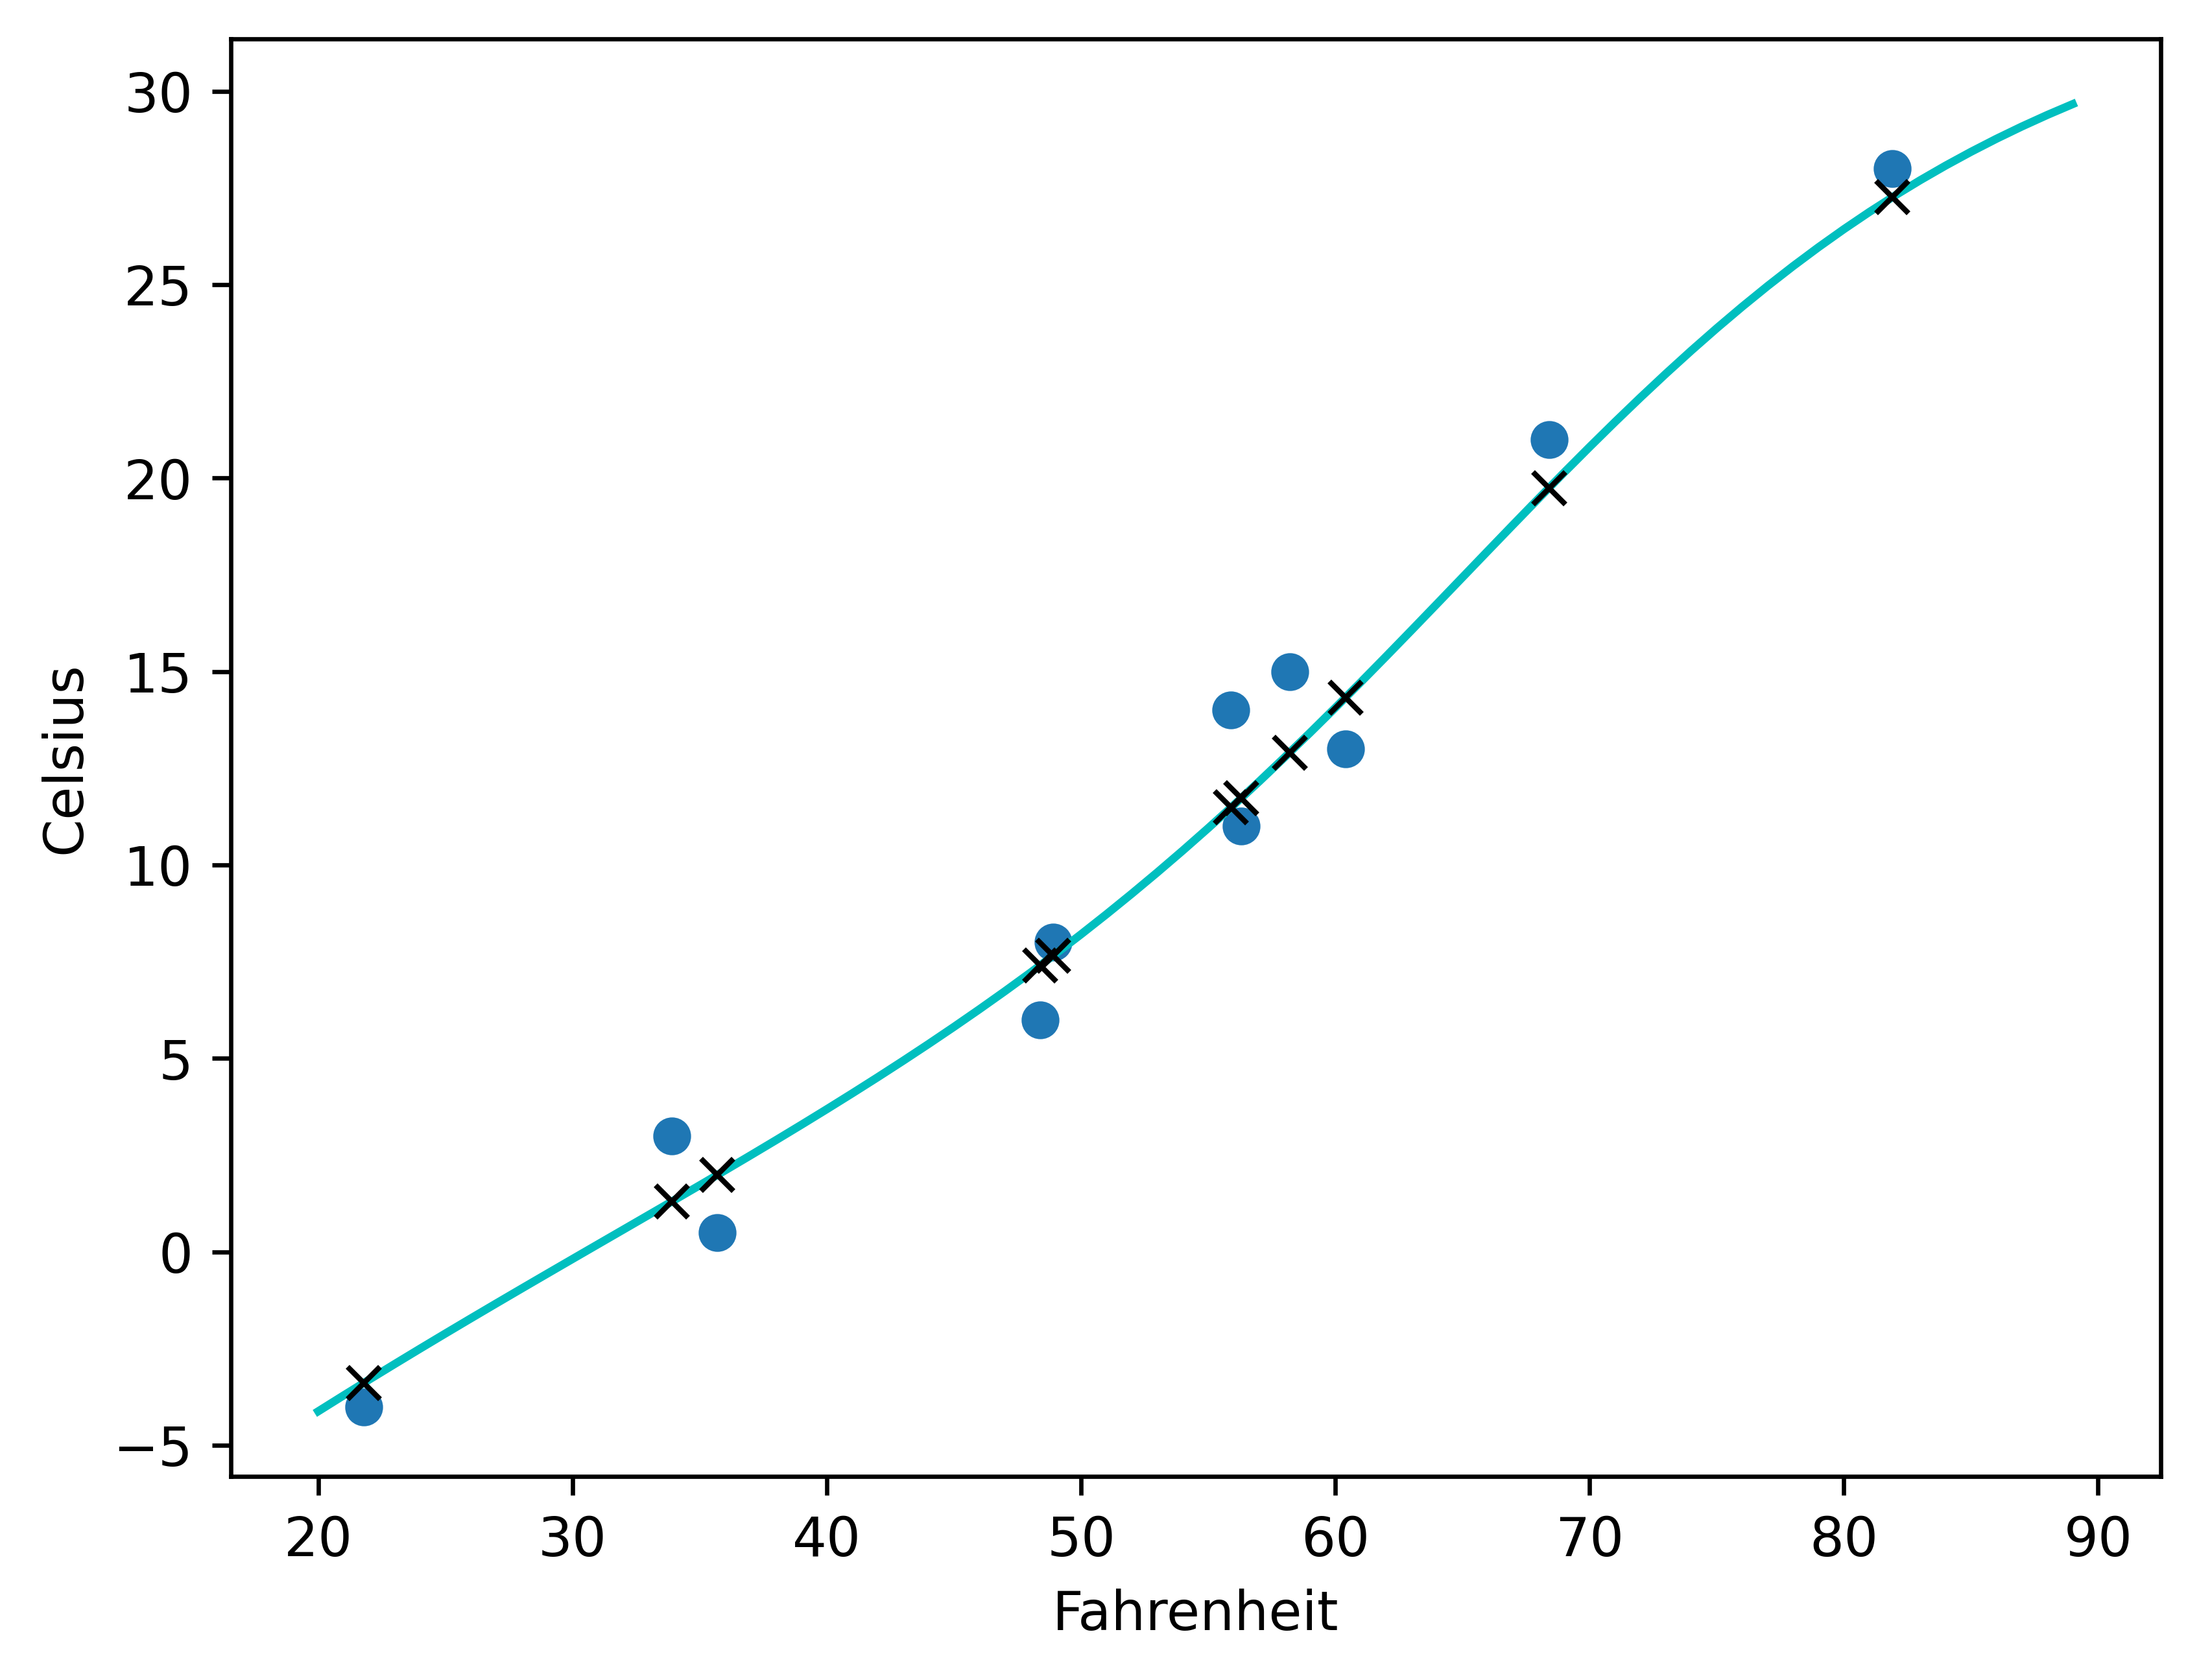

In [24]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')